# Predictive Model for the Environment

In this notebook, we attempt to train a model that given the observations and the agent input, can predict the next feature vector. More precisely, given r, r', x, x', f, estimate d(r), d(r'), d(x), d(x') for the next time step.

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
import sys, os
import importlib, time
from scipy.special import expit as sigmoid
from functools import partial
import numpy as np
from numpy import asarray as narr
import matplotlib.pyplot as plt

import env
importlib.reload(env)
from env import PhysicalDyads

### Train one network to learn the model
control: P controller +N(0,sigma)

In [4]:
class PDAgent:

    # internal methods
    def __init__(self, agent_id, pcont, sigma,
                 q_init=None,
                 seed_=None, config_file=None, **kwargs):
        
        # Read the kwargs and override params from config file.
        for key in kwargs:
            setattr(self, key, kwargs[key])
                
                
        self.id = agent_id
#         self.nS = nS
#         self.nA = nA
#         self.discretize = discretizer
#         self.integrate = integrator
        
        self.pd = pcont
        self.sigma = sigma
            
#         self.s_new, self.a_new, self.force_new = 0, 0, 0.
    
    # interface
    def get_force(self, observations, f_old):
        state = observations #self.discretize(observations)
        e = observations[0]-observations[2]
        ed = observations[1]-observations[3]
        force = np.dot(self.pd, [e,ed]) #f_old+np.dot(self.pd, [e,ed]) 
        noisy_force = force+np.random.normal(0, self.sigma)
        force_capped = 19.99*np.tanh(0.1*noisy_force)
        return force_capped

In [10]:

class DeepNet(nn.Module):
# Inputs:
# r, r', x, x', f_n, f_n', f1
# Outputs:
# dr, dr', dx, dx', df_n, df_n'
#     def __init__(self, nin, nout):
#         super(PredictiveNet, self).__init__()
#         self.fc1 = nn.Linear(nin, 20)
#         self.fc2 = nn.Linear(20, nout)
        
#     def forward(self, x):
#         z1 = F.relu(self.fc1(x))
#         out = self.fc2(z1)
#         return out

    def __init__(self, nin, nout):
        super(PredictiveNet, self).__init__()
        self.fc1 = nn.Linear(nin, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, nout)
        
    def forward(self, x):
        z1 = F.relu(self.fc1(x))
        z2 = F.relu(self.fc2(z1))
        z3 = F.relu(self.fc3(z2))
        out = self.fc4(z3)
        return out
    

class LinearNet(nn.Module):
# Inputs:
# r, r', x, x', f_n, f_n', f1
# Outputs:
# dr, dr', dx, dx', df_n, df_n'
    def __init__(self, nin, nout):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(nin, nout, bias=False)
        
    def forward(self, x):
        out = self.fc1(x)
        return out

In [11]:
class ExperienceBuffer():
    def __init__(self, maxsize, tol=0.01):
        self.maxsize = maxsize
        self.data = deque([], maxlen=maxsize)
        self.target = deque([], maxlen=maxsize)
        self.tolerance = tol
#         self.size = 0
            
    def append(self, data, target):
        self.data.appendleft(data)
        self.target.appendleft(target)
#         self.size =len(self.data)
        
    def sample_batch(self, size):
        self_size = len(self.data)
        if size>self_size:
            sample_size = self_size
        else:
            sample_size = size
        mask = np.random.randint(self_size, size=sample_size)
        return narr(self.data)[mask], narr(self.target)[mask]
    
    def __len__(self):
        return len(self.data)

In [12]:
def train(env, actor, optimizer, criterion, hyperparams, model, buffer):
    # required imports:
    # numpy as np; torch

    batch_size, _,_,_ = hyperparams
    observations = env.reset(renew_traj=True); old_observations = np.asarray(observations)
    f1 = actor(observations, 0.) #initalize s_old, a_old
    f2 = 0
    ftr_vec = observations+[f1]

    while True:
        t = env.get_time()
        observations, reward, done, _ = env.step([f1, f2])
        observations_arr = np.asarray(observations)
        outcome = observations_arr-old_observations#+ [reward]

        err = observations[0]-observations[2]
        if err> env.max_err*buffer.tolerance:
            buffer.append(ftr_vec, outcome)

        # Train the model
        # Create a minibatch
        if len(buffer)>0:
            batch_size_ = min(len(buffer), batch_size)
            data, target = buffer.sample_batch(batch_size_)
            # Run one step of SGD using the whole batch data
            data, target = torch.from_numpy(data).float(), torch.from_numpy(target).float()
            optimizer.zero_grad() #zero all of the gradients
            prediction = model(data)
            loss = criterion(prediction, target)
            loss.backward()# Backward pass: compute gradient of the loss with respect to model parameters.
            optimizer.step()# Update model parameters

        ###
        f1 = actor(observations, f1)
        old_observations = observations_arr
        ftr_vec =  observations+[f1]

        if done is True:
            break
    return model, buffer

In [24]:
def ndrms(x, axis=0):
    return np.sqrt(np.mean(x**2, axis=axis))

# xtt = np.asarray([[1,2],[1,2], [1,2], [1,2], [1,2]])
# ndnorm(xtt, axis=0)

In [44]:
# Benchmark

def model_eval(env, actor, model, n_episodes=100, normalizer=None):
    # Empirical Model Evaluation
    # For predicting the (diff) next state by neural net
    # Arguments:
    # n_episodes: the number of episodes used for averaging the quality of the policy
    # normalize: if True, the reward is normalized by the number of time steps.

    n_steps_max = env._max_episode_steps

    all_loss = np.zeros((n_episodes, env.observation_space.shape[0]))


    for i_episode in range(n_episodes):
        ep_loss = torch.zeros(env.observation_space.shape[0])
        observations = env.reset(renew_traj=True); old_observations = np.asarray(observations)
        f1 = actor(observations, 0.) #initalize s_old, a_old
        f2 = 0
        ftr_vec = observations+[f1]

        while True:
            t = env.get_time()
            observations, reward, done, _ = env.step([f1, f2])
            observations_arr = np.asarray(observations)
            outcome = observations_arr-old_observations
            ftr_tensor, outcome_tensor = torch.FloatTensor(ftr_vec), torch.from_numpy(outcome).float()
            prediction = model(ftr_tensor)
            
            ep_loss += abs(prediction-outcome_tensor)
            
            f1 = actor(observations, f1)
            old_observations = observations_arr
            ftr_vec =  observations+[f1]

            if done is True:
                break
   
        ep_loss = ep_loss.detach().numpy() /t
        if normalizer is not None:
            all_loss[i_episode,:] = ep_loss /normalizer
        else:
            all_loss[i_episode,:] = ep_loss
        
    return np.mean(all_loss, axis=0)
    
    
def get_ftr_outcome_rms(env, actor, n_episodes=1):
    n_steps_max = env._max_episode_steps
    
    ftrs = []
    outcomes = []

    for i_episode in range(n_episodes):
        ftr_i=[]; outcome_i = []
        
        observations = env.reset(renew_traj=True); old_observations = np.asarray(observations)
        f1 = actor(observations, 0.) #initalize s_old, a_old
        f2 = 0
        ftr_vec = observations+[f1]
        ftr_i.append(ftr_vec)

        while True:
            t = env.get_time()
            observations, reward, done, _ = env.step([f1, f2])
            observations_arr = np.asarray(observations)
            outcome = observations_arr-old_observations
            outcome_i.append(outcome)
            
            f1 = actor(observations, f1)
            old_observations = observations_arr
            ftr_vec =  observations+[f1]

            if done is True:
                break
   
        ftrs.append(ndrms(np.asarray(ftr_i), axis=0))
        outcomes.append(ndrms(np.asarray(outcome_i), axis=0))
        
    ftrs_rms = np.mean(np.asarray(ftrs), axis=0)
    outcomes_rms = np.mean(np.asarray(outcomes), axis=0)
    return ftrs_rms, outcomes_rms
    
    
    
def benchmark(algo, hyperparams, model, env, actor, xaxis_params):
    # Creates time series for algorithm quality across episodes
    
    # Unzip arguments
    batch_size, _, buffer_max_size, experience_sift_tol = hyperparams
    n_episodes, n_intervals, n_eval = xaxis_params
    int_episodes=int(n_episodes/n_intervals)
#     # train(env, actor, optimizer, criterion, hyperparams, model, buffer)
#     algo = partial(train, env, actor, optimizer, criterion)
    
    buffer = ExperienceBuffer(buffer_max_size, tol=experience_sift_tol)
    
    x, y = np.zeros(n_intervals+1), np.zeros((env.observation_space.shape[0], n_intervals+1))
    
    _, outcomes_rms = get_ftr_outcome_rms(env, actor, n_episodes=3)
    outcomes_rms += 0.00001*(outcomes_rms==0)
    
    print("outcomes_rm = ", outcomes_rms)
    x[0] = 0
    y[:,0] = model_eval(env, actor, model, n_episodes=n_eval, normalizer=outcomes_rms)
    
    # Evaluate the created policy once every int_episodes episodes
    for i in range(n_intervals):
#         if i%10==0: 
        print('interval ', i, ': loss= ', y[:,i])
        
        for j in range(int_episodes):
            model, buffer = algo(hyperparams, model, buffer)
        x[i+1] = (i+1)*int_episodes
        y[:, i+1] = model_eval(env, actor, model, n_episodes=n_eval, normalizer=outcomes_rms)

    return x,y, model
        

outcomes_rm =  [2.77819222e-03 2.52039013e-03 4.36660679e-03 1.02387731e-01
 1.73774443e+00 1.20644891e+02]
interval  0 : loss=  [5.63134356e+03 6.30973174e+03 3.80267264e+03 3.76575056e+01
 1.15949109e+00 9.18601701e-01]
interval  1 : loss=  [2.25800958e+01 6.83254957e+00 2.94069071e+00 1.02734593e-02
 3.79861799e-01 3.12571382e-01]
interval  2 : loss=  [0.00607175 0.47786399 0.0039679  0.01139789 0.44838716 0.2588044 ]
interval  3 : loss=  [0.00614605 0.57220527 0.00411622 0.01071751 0.41474329 0.22697866]
interval  4 : loss=  [1.4816561  1.83841557 0.02345286 0.01351342 0.44527982 0.21220381]
interval  5 : loss=  [0.00705494 1.10303427 1.46893667 0.01397461 0.48800119 0.2110743 ]
interval  6 : loss=  [0.00723824 0.6655962  0.00330584 0.0388779  0.40657313 0.20847973]
interval  7 : loss=  [0.27842842 0.48716932 0.00363149 0.01116686 0.42838222 0.20754819]
elapsed_t:  456.2767734527588


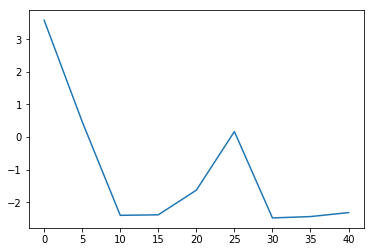

In [45]:
# Main

# Fixed objects and hyperparameters
pdcont = [0.6, 2.]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
sigma = 1.
agent1 = PDAgent('pd_agent', pdcont, sigma)
seed = 1234
env = PhysicalDyads(seed_=seed, max_freq=0.2)
#___________________________________________


#Benchmark x-axis related
n_episodes = 40
n_intervals = 8 
n_eval = 5

# Buffer-related
experience_sift_tol = 0.01
buffer_max_size = 10000

# Algo hyperparams
learning_rate=0.001
batch_size=128
# initializer = None

# Boilerplate code
model = LinearNet(7, 6)#DeepNet(7, 6)
actor = agent1.get_force

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
hyperparams = (batch_size, learning_rate, buffer_max_size, experience_sift_tol)
xaxis_params = (n_episodes, n_intervals, n_eval)

t0 = time.time()
# train(env, actor, optimizer, criterion, hyperparams, model, buffer)
algo = partial(train, env, actor, optimizer, criterion)
x_f1, y_f1, trained_model = benchmark(algo, hyperparams, model, env, actor, xaxis_params)
elapsed_t = time.time() - t0
print('elapsed_t: ', elapsed_t)

plt.plot(x_f1, np.log10(y_f1[2,:]))

Text(0, 0.5, 'Log10 Prediction Loss')

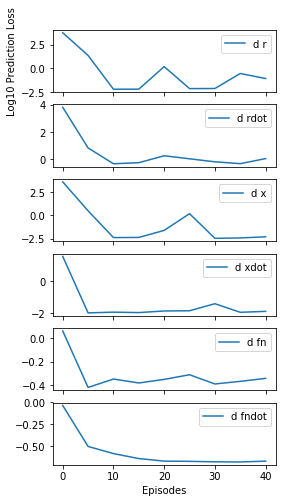

In [50]:
fig,ax = plt.subplots(6,1, figsize=(4,8), sharex=True)
ax[0].plot(x_f1, np.log10(y_f1[0,:]), label='d r')
ax[1].plot(x_f1, np.log10(y_f1[1,:]), label='d rdot')
ax[2].plot(x_f1, np.log10(y_f1[2,:]), label='d x')
ax[3].plot(x_f1, np.log10(y_f1[3,:]), label='d xdot')
ax[4].plot(x_f1, np.log10(y_f1[4,:]), label='d fn')
ax[5].plot(x_f1, np.log10(y_f1[5,:]), label='d fndot')
for _,axi in np.ndenumerate(ax):
    axi.legend()
ax[-1].set_xlabel('Episodes')
ax[0].set_ylabel('Log10 Prediction Loss')

In [54]:
fw_weights = trained_model.fc1.weight
fw_weights = fw_weights.detach().numpy()

Text(0.5, 1.0, 'Weights')

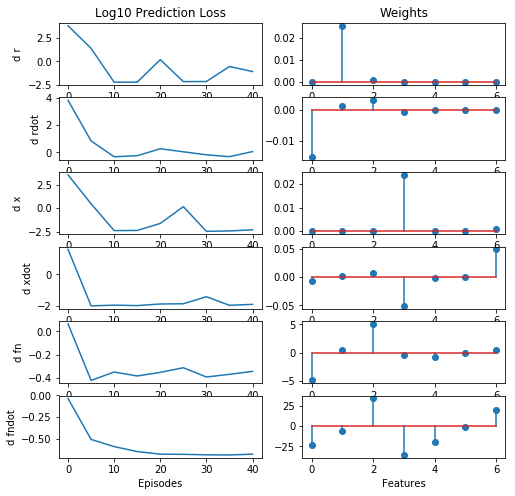

In [66]:
fig,ax = plt.subplots(6,2, figsize=(8,8))
labels = ['d r','d rdot', 'd x', 'd xdot','d fn', 'd fndot']
ax[0,0].plot(x_f1, np.log10(y_f1[0,:])); ax[0,1].stem(fw_weights[0,:])
ax[1,0].plot(x_f1, np.log10(y_f1[1,:])); ax[1,1].stem(fw_weights[1,:])
ax[2,0].plot(x_f1, np.log10(y_f1[2,:])); ax[2,1].stem(fw_weights[2,:])
ax[3,0].plot(x_f1, np.log10(y_f1[3,:])); ax[3,1].stem(fw_weights[3,:])
ax[4,0].plot(x_f1, np.log10(y_f1[4,:])); ax[4,1].stem(fw_weights[4,:])
ax[5,0].plot(x_f1, np.log10(y_f1[5,:])); ax[5,1].stem(fw_weights[5,:])
for i in range(6):
    ax[i,0].set_ylabel(labels[i])
ax[-1,0].set_xlabel('Episodes'); ax[-1,1].set_xlabel('Features')
ax[0,0].set_title('Log10 Prediction Loss')
ax[0,1].set_title('Weights')

The loss decreases nicely and the weights look reasonably similar to the ground truth. Except for fn, fndot, which don't have a ground truth and any arbitrary set of weights work as long as they give zero. The reason they already aren't zero is probably the random initialization.

### Appendix: verifying the training data

The force generated by the actor is the sum of a PID and a noise signal. The goal is producing a force that gives rise to a variety of useful feature vectors (error and force)

In [222]:
# observations = env.reset(renew_traj=True); observations = narr(observations)
# ftr_vec = observations
# f1 = agent1.get_force(observations, 0.) #initalize s_old, a_old
# f2 = 0

# e_ts = []
# f_ts = []
# # f2,_,_ = agent2.get_action(observations, eps)

# while True:
#     t = env.get_time()
#     observations, reward, done, _ = env.step([f1, f2])
#     observations = narr(observations)
#     outcome = [observations-ftr_vec, reward]
    
#     err = observations[0]-observations[2]
#     e_ts.append(err) # Logging
#     f_ts.append(f1) # Logging
# #     print('err = ', err)
# #     print('f1', f1)
#     if err> env.max_err*0.05:
#         buffer.append((ftr_vec, outcome))
    
#     # Train the model
#     # Create a minibatch
#     # loss = MSE(outcome, model.predict)
#     # Update the model using data
#     ###
#     ftr_vec =  observations
#     f1 = agent1.get_force(observations, f1)
    
#     if done is True:
#         break
# #     return agent1, agent2

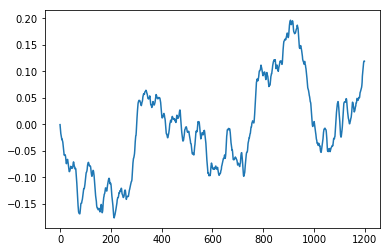

In [209]:
# Noisy Tracking Error
plt.plot(e_ts)

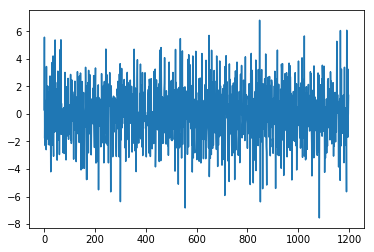

In [210]:
# Noisy Force of the actor
plt.plot(f_ts)